In [1]:
%matplotlib inline

from itertools import combinations
import os
import sys

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np

from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri

from scipy.stats import spearmanr

pd.set_option("display.max_columns", 101)
pd.set_option("display.float_format", lambda x: "%.2f" % x )

# Explore Target Variables

There are four potential target variables that we're interested in predicting. We expect some correlation among these targets, so for now we want to explore which regions are covered and during what time periods.

 - **Crop Yield**: Direct measure of the agricultural productivity in certain regions in Kenya.
 - **Income/Wealth**: we expect this to be highly correlated with crop yield in farming regions.
 - **Household Expenditure**: Also a metric for income/wealth but measured in a different survey.
 - **Loan repayment**: Ultimately, we want to predict repayment rates for loans from FarmDrive. Since historical data for FarmDrive is sparse, we'll look at other loan data that is available.

## Crop Yield

First, we have crop yield for administrative units (larger than counties) in Kenya.

In [2]:
crop_yield = pd.read_csv("../data/raw/Crop Yield/Admin Level 1 - Crops in Tons.csv")
print(crop_yield['Administrative level 1'].unique())
crop_yield.head()

['Western' 'Rift Valley' 'North Eastern' 'Nyanza' 'Central' 'Coast'
 'Eastern' 'Nairobi']


,Year,Administrative level 1 (code),Administrative level 1,Product (code),Product,Value,Flag
0,2008,51332,Western,197,Pigeon peas,nan,..
1,2008,51332,Western,176,"Beans, dry",44031.00,NaN
2,2008,51332,Western,125,Cassava,194646.00,NaN
3,2008,51332,Western,195,"Cow peas, dry",2354.00,NaN
4,2008,51332,Western,56,Maize,362040.00,NaN


Second, we have data scraped from the [Agricultural Sector](http://www.asdsp.co.ke/index.php)'s websites for each county.

### Site is currently down, so scraping failed. Will retry when it is back up...

## Mean household expenditure

In [3]:
income = pd.read_excel("../data/raw/Socio Econonomic Data/KIHBS2005/Final Poverty Estimates All.xls",
                       header=1,
                       sheetname='Sublocation',
                       index_col=0)
income.head()

,Headcount Index: Percent of Individuals below Poverty Line,Standard Error of Headcount Index,Poverty Gap as Percent of Poverty Line,Standard Error of Poverty Gap,Severity of Poverty as Percent of Poverty Line,Standard Error of Severity of Poverty,Wealth gap index as Percent of Poverty Line,Standard Error of Wealth gap index,Mean Expenditure,Gini Coefficient,County Contribution to National Poverty (%),Total Population
County/District/Division/Location/Sub Location,,,,,,,,,,,,
KENYA NATIONAL,45.22,0.08,12.24,0.04,4.89,0.02,68.40,nan,3440.00,0.45,nan,37565589
NAIROBI COUNTY,21.80,0.20,4.10,0.06,1.20,0.03,152.45,1.00,7230.00,0.34,3.94,3068835
NAIROBI WEST DISTRICT,25.70,0.44,5.20,0.12,1.50,0.04,152.09,2.45,7190.00,0.36,1.01,669647
DAGORETTI DIVISION,24.50,0.50,4.40,0.11,1.10,0.04,141.39,2.72,6900.00,0.34,0.47,323581
KAWANGWARE LOCATION,34.50,0.80,6.50,0.20,1.70,0.10,96.63,2.60,5540.00,0.34,0.23,112965


(47, 12)


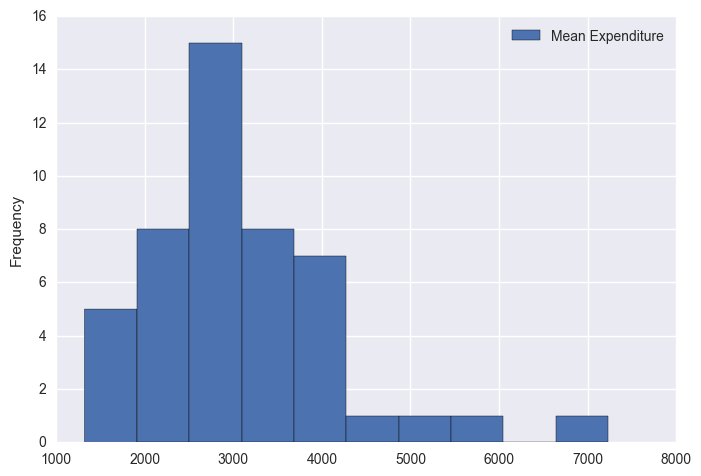

In [4]:
county_income = income[income.index.str.contains('COUNTY')]

print(county_income.shape)
expenditure_target = county_income['Mean Expenditure'].to_frame()
expenditure_target.plot.hist()

## Wealth index (from DHS)

In [5]:
foreign = importr('foreign')

fp = os.path.abspath("../data/raw/Socio Econonomic Data/DHS/KE_2014_DHS_10202016_1854_100338/kehr70sv/KEHR70FL.SAV")

r_data_frame = foreign.read_spss(str(fp), to_data_frame=True)
dhs2014 = pandas2ri.ri2py_dataframe(r_data_frame)

dhs2014.head()

/Users/bull/anaconda/envs/farmdrive/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:185: RRuntimeWarning: re-encoding from CP1252

  warnings.warn(x, RRuntimeWarning)


,HHID,HV000,HV001,HV002,HV003,HV004,HV005,HV006,HV007,HV008,HV009,HV010,HV011,HV012,HV013,HV014,HV015,HV016,HV017,HV018,HV019,HV020,HV021,HV022,HV023,HV024,HV025,HV026,HV027,HV028,HV030,HV031,HV032,HV035,HV040,HV041,HV042,HV044,HV201,HV202,HV204,HV205,HV206,HV207,HV208,HV209,HV210,HV211,HV212,HV213,...,HML34.20,HML34.21,HML34.22,HML34.23,HML35.01,HML35.02,HML35.03,HML35.04,HML35.05,HML35.06,HML35.07,HML35.08,HML35.09,HML35.10,HML35.11,HML35.12,HML35.13,HML35.14,HML35.15,HML35.16,HML35.17,HML35.18,HML35.19,HML35.20,HML35.21,HML35.22,HML35.23,SHML12.01,SHML12.02,SHML12.03,SHML12.04,SHML12.05,SHML12.06,SHML12.07,SHML12.08,SHML12.09,SHML12.10,SHML12.11,SHML12.12,SHML12.13,SHML12.14,SHML12.15,SHML12.16,SHML12.17,SHML12.18,SHML12.19,SHML12.20,SHML12.21,SHML12.22,SHML12.23
1,0001002,KE6,1.00,2.00,1.00,1.00,5185577.00,8.00,2014.00,1376.00,1.00,0.00,0.00,1.00,1.00,0.00,Completed,19.00,1.00,176.00,7.00,All woman sample,1.00,1.00,1.00,Nairobi,Urban,"Capital, large city",Not selected,0.00,175.00,177.00,6.00,0.00,nan,0.00,Not selected,Household not selected,Piped to yard/plot,PIPED WATER,996.00,Pit latrine with slab,Yes,Yes,Yes,No,No,No,No,Cement,...,Sample damaged/insufficient/not found in lab,Sample damaged/insufficient/not found in lab,Sample damaged/insufficient/not found in lab,Sample damaged/insufficient/not found in lab,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net
2,0001006,KE6,1.00,6.00,1.00,1.00,5185577.00,8.00,2014.00,1376.00,4.00,1.00,0.00,4.00,4.00,1.00,Completed,23.00,2.00,180.00,7.00,All woman sample,1.00,1.00,1.00,Nairobi,Urban,"Capital, large city",Men's survey,5275262.00,175.00,177.00,6.00,0.00,nan,1.00,Not selected,Household not selected,Public tap/standpipe,PIPED WATER,20.00,Pit latrine with slab,Yes,Yes,Yes,No,No,No,No,Cement,...,Sample damaged/insufficient/not found in lab,Sample damaged/insufficient/not found in lab,Sample damaged/insufficient/not found in lab,Sample damaged/insufficient/not found in lab,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Negative,Did not sleep under a net,Did not sleep under a net,Only treated (ITN) nets,Only treated (ITN) nets,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net,Did not sleep under a net
3,0001011,KE6,1.00,11.00,3.00,1.00,5185577.00,8.00,2014.00,1376.00,4.00,1.00,0.00,4.00,4.00,1.00,Completed,19.00,1.00,180.00,7.00,All woman sample,1.00,1.00,1.00,Nairobi,Urban,"Capital, large city",Not selected,0.00,175.00,177.00,6.00,1.00,nan,0.00,Not selected,Household not selected,Public tap/standpipe,PIPED WATER,10.00,Pit latrine with slab,Yes,Yes,Yes,No,No,No,No,Cement,...,Sample damaged/insufficient/not found in lab,Sample damaged/insufficient/not found in lab,Sample damaged/insuff

In [6]:
dhs_wealth = dhs2014[['HV005', 'HV271', 'SHREGION']]
dhs_wealth.columns = ['survey_weight', 'wealth_index', 'county']
dhs_wealth.head()

,survey_weight,wealth_index,county
1,5185577.00,103434.00,Nairobi
2,5185577.00,89121.00,Nairobi
3,5185577.00,107389.00,Nairobi
4,5185577.00,74834.00,Nairobi
5,5185577.00,46865.00,Nairobi


### Apply survey weights to incomes,

```
HV005 Sample weight is an 8 digit variable with 6 implied decimal places. To use the sample
weight divide it by 1000000 before applying the weighting factor. All sample weights are
normalized such that the weighted number of cases is identical to the unweighted number of
households when using the full dataset with no selection. This variable should be used to
weight all tabulations produced using the data file. For self-weighting samples this variable
is equal to 1000000. 
```

In [7]:
dhs_wealth['weighted_wealth'] = dhs_wealth.wealth_index * (dhs_wealth.survey_weight / 1000000)

/Users/bull/anaconda/envs/farmdrive/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


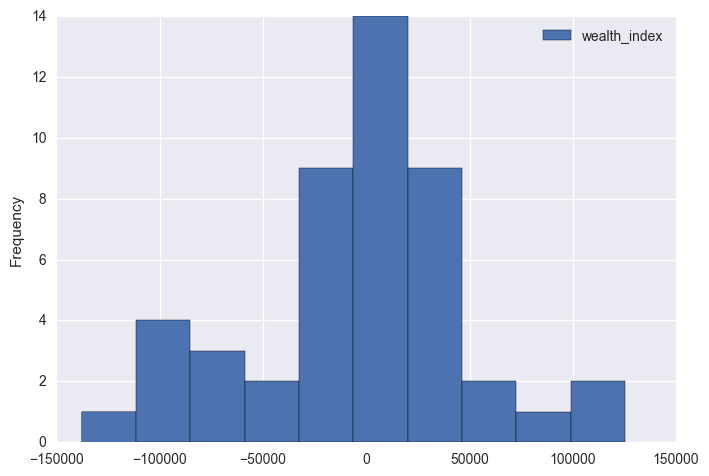

In [8]:
wealth_target = dhs_wealth[['county', 'wealth_index']].groupby('county').mean()

wealth_target.plot.hist()

## Loan Repayment

In [9]:
foreign = importr('foreign')

fp = os.path.abspath("../data/raw/Socio Econonomic Data/FinAccess2016/FinAccess_2016_data_final_anonymized_SPSS.sav")

r_data_frame = foreign.read_spss(str(fp), to_data_frame=True)
finaccess2016 = pandas2ri.ri2py_dataframe(r_data_frame)

finaccess2016.head()

,sbjnum,sub_region,a2,a3,a4,a5,a6,a7,a8_1,a8_2,cluster_type,a_7_1,a_7_2,a_7_3,a_7_4,gender_of_household_head,gender_of_household_spouse,gender_of_respondent,age,a_8,stime,end_time,duration,a_9,a_10,a_11,a_12,a_13,a_13_10_1,a_14,a_15_1,a_15_2,a_15_3,a_16,b1_1,b1_2,b2_1,b2_2,b2_3,b2_4,b2_5,b2_6,b2_7,b2_8,b2_9,b3_1,b3_2,b3_3,b3_4,b3_5,...,trans_atm,trans_mm,sav_post,sav_sa,sav_mfi,sav_asca,sav_rosca,sav_gof,sav_fam,sav_sp,sav_bsa,credit_pbl,credit_mb,credit_sal,credit_mfi,credit_gl,credit_el,credit_asl,credit_chama,credit_fam,credit_inf,credit_app,credit_shp,credit_bc,credit_hbl,credit_hgl,credit_od,credit_cc,credit_hp,inspen_car,inspen_hse,inspen_pm,inspen_life,inspen_nhif,inspen_ed,inspen_ra,inspen_nssf,transactions_usage,savings_usage,credit_usage,investment_usage,pension_usage,pension_usage1,mobile,informalgp_cont,livelihoodcat,livelihoodcat2,monthly_income,incomegp,vul_index
1,23559537.00,LOWER EASTERN,MAKUENI,MAKUENI,WOTE,WOTE,KAMUNYOLO,SLAUGHTER,2275.00,100.00,Urban,3.00,1.00,0.00,1.00,Female,No spouse,Female,21.00,Kamba,33305.50,35729.90,2424.41,Married/Living with partner,Other relative,Christianity,No,"Natural disaster (drought, floods, earthquake ...","Natural disaster (drought, floods, earthquake ...",Secondary completed,None,National Identity Card (ID) Kitambulisho,National Identity Card (ID) Kitambulisho,Primary completed,Other relatives,None,Yes,Yes,Yes,No,Yes,Yes,Yes,Yes,No,Yes,Yes,No,No,No,...,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,0.00,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Never had,Currently have,Used to have,Never had,Never had,Never had,Yes,KSh0-50,Dependent,Casual,8000.00,KSh7501-15000,Least Vulnerable
2,23266247.00,CENTRAL RIFT,TRANS NZOIA,TRANS NZOIA WEST,KIMININI,KIMININI,KIMININI,KAMBI MIWA,404.00,30.00,Rural,2.00,2.00,0.00,0.00,Male,Female,Female,56.00,Swahili,45589.06,47413.41,1824.35,Married/Living with partner,Spouse,Christianity,No,"Natural disaster (drought, floods, earthquake ...","Natural disaster (drought, floods, earthquake ...",Some primary (specify level reached),National Identity Card (ID) Kitambulisho,National Identity Card (ID) Kitambulisho,National Identity Card (ID) Kitambulisho,Some primary (specify level reached),Spouse,You,Yes,No,No,No,No,No,No,Yes,No,Yes,Yes,No,No,No,...,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,No,0.00,No,No,Yes,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Never had,Used to have,Currently have,Never had,Never had,Never had,No,KSh0-50,Casual,Own Business,2000.00,KSh1501-3000,Vulnerable
3,23647292.00,NORTH RIFT,WEST POKOT,POKOT CENTRAL,TAPACH,SONDANY,KALE,PARAYON,392.00,81.00,Rural,8.00,2.00,4.00,6.00,Male,Female,Male,21.00,English,65520.00,67800.00,2280.00,Single,Son/Daughter,Christianity,No,"Natural disaster (drought, floods, earthquake ...","Natural disaster (drought, floods, earthquake ...",Some primary (specify level reached),National Identity Card (ID) Kitambulisho,National Identity Card (ID) Kitambulisho,National Identity Card (ID) Kitambulisho,None,Parents,None,No,No,No,No,No,No,No,No,No,Yes,Yes,No,No,No,...,No,No,No,No,No,No,No,No,No,Yes,No,No,No,No,No,No,0.00,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Never had,Never had,Never had,Never had,Never had,Never had,Yes,KSh0-50,Agric,Other,14000.00,KSh7501-15000,Vulnerable
4,23312411.00,UPPER EASTERN,ISIOLO,ISIOLO,MERTI,MERTI,MERTI NORTH,SAKUYE,881.00,25.00,Urban,9.00,0.00,7.00,5.00,Male,Female,Female,35.00,Swahili,62756.76,66005.25,3248.49,Married/Living with partner,Spouse,Islam,No,"Natural disaster (drought, floods, earthquake ...","Natural disaster (drought, floods, earthquake ...",None,National Identity Card (ID) Kitambulisho,National Identity Card (ID) Kitambulisho,National Identity Card (ID) Kitambulisho,None,Spouse,You,No,No,No,No,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,0.00,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,No,Never had,Never had,Never had,Never had,Never had,Never had,No,KSh0-50,Own

In [10]:
# mask for difficulty repaying
#    b11_7: sold asset to repay
#    b11_8: got loan to repay
difficulty_mask = ((finaccess2016.b11_7 == 'Agree') |
                   (finaccess2016.b11_8 == 'Agree'))

#    j8_*: >1 is some difficulty or very difficult to repay (formal loans)
j8_answers = finaccess2016.iloc[:, finaccess2016.columns.str.startswith('j8_')]
difficulty_mask |= ((j8_answers == 'Some difficulty').any(axis=1) |
                    (j8_answers == 'Very difficult').any(axis=1))


#    j14_*: >1 is some difficulty or very difficult to repay (informal loans)
j14_answers = finaccess2016.iloc[:, finaccess2016.columns.str.startswith('j14_')]
difficulty_mask |= ((j14_answers == 'Some difficulty').any(axis=1) |
                    (j14_answers == 'Very difficult').any(axis=1))

# question is "have never had loan"
finaccess2016['have_had_loan'] = (finaccess2016.e4_8 == 'No')

finaccess2016['some_difficulty_repaying'] = difficulty_mask

/Users/bull/anaconda/envs/farmdrive/lib/python3.5/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


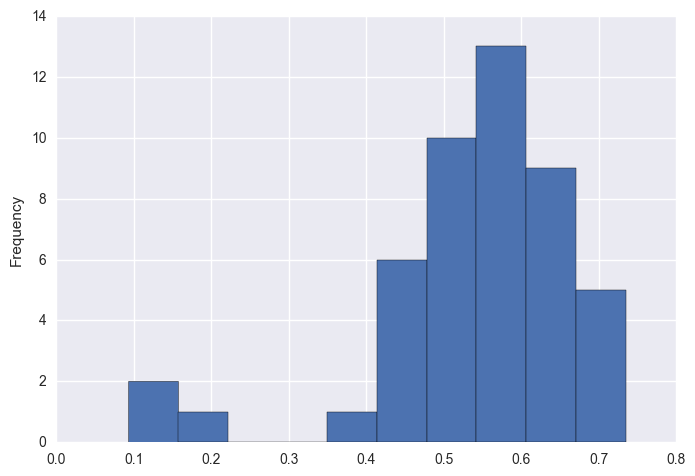

In [11]:
# just look at population who have had a loan
have_had_loan = finaccess2016[finaccess2016.have_had_loan]

# weight our results with survey weights
have_had_loan['cnt'] = have_had_loan.popwgt_normalized

# group by the county
difficulty_by_county = (have_had_loan[['a2', 'some_difficulty_repaying', 'cnt']]
                         .groupby(['a2', 'some_difficulty_repaying'])
                         .sum()
                         .unstack(level=-1))

difficulty_by_county.columns = ['No', 'Yes']

difficulty_by_county['pct_no_difficulty'] = difficulty_by_county['No'] / difficulty_by_county.sum(axis=1)
difficulty_by_county.pct_no_difficulty.plot.hist(bins=10)

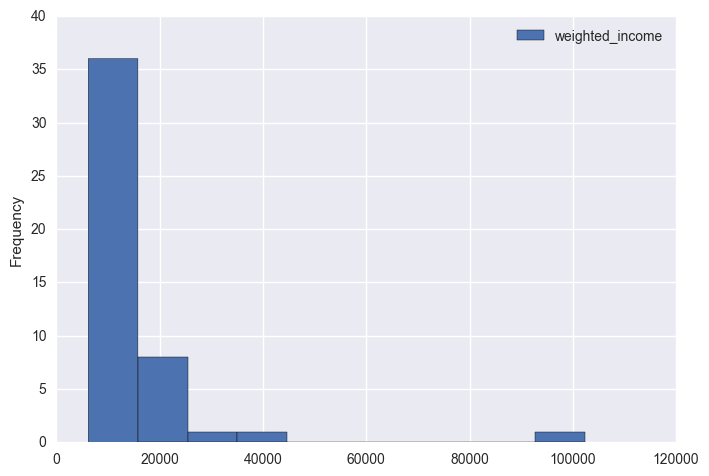

In [12]:
# weight our results with survey weights
finaccess2016['weighted_income'] = finaccess2016.monthly_income * finaccess2016.popwgt_normalized

# group by the county
monthly_income_by_county = (finaccess2016[['a2', 'weighted_income']]
                                 .groupby('a2')
                                 .mean())

monthly_income_by_county.plot.hist()

## Look at Different Targets

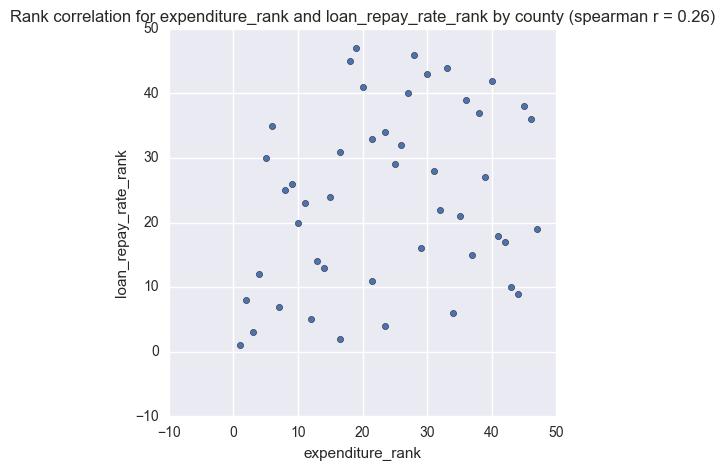

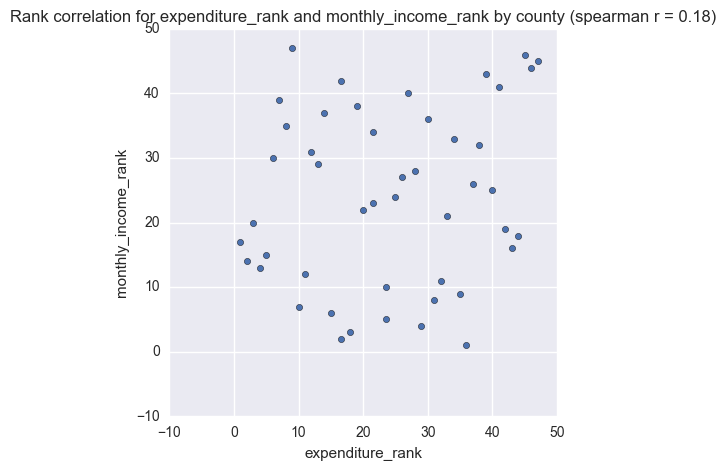

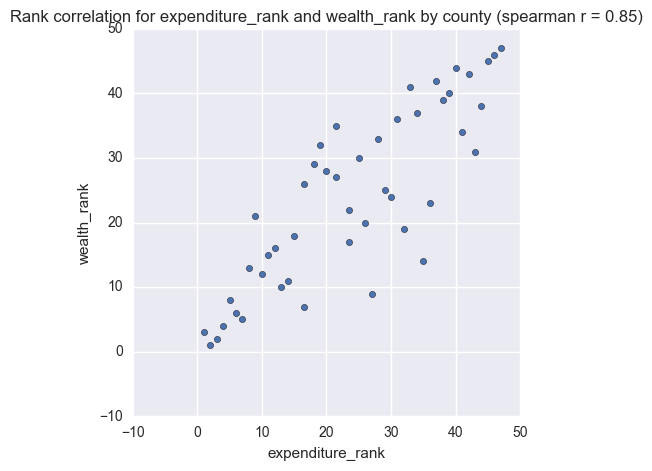

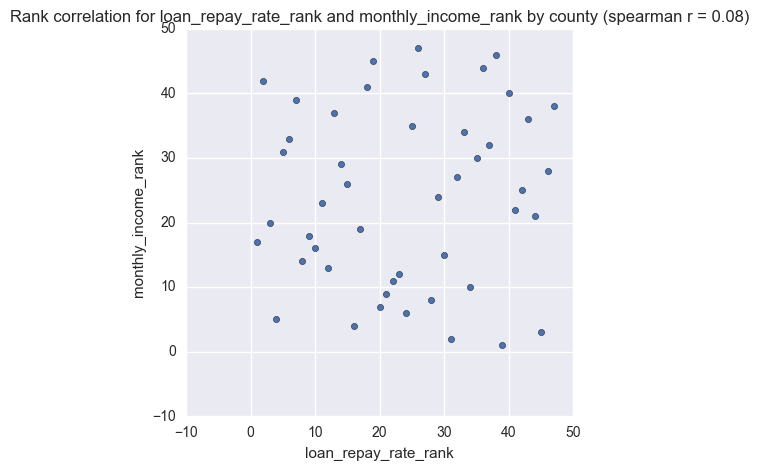

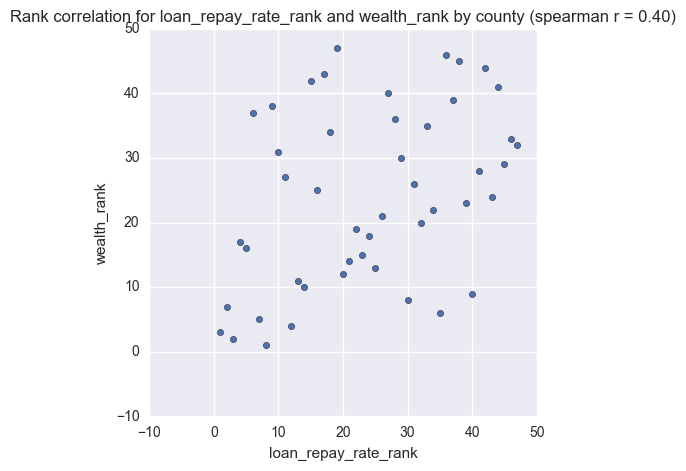

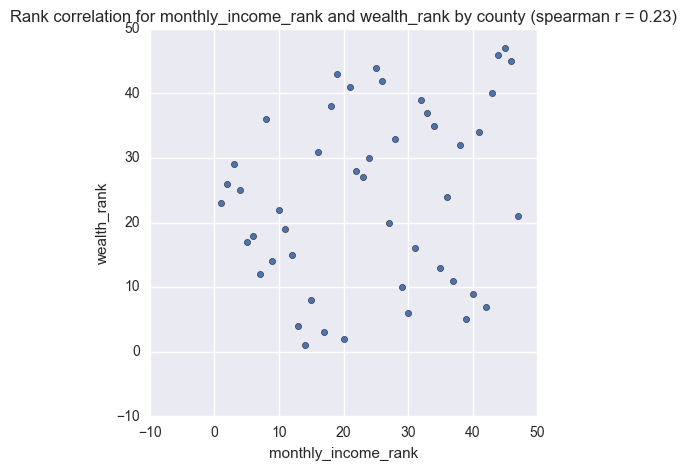

In [15]:
# sort so counties are all in the same order
difficulty_by_county.sort_index(inplace=True)
wealth_target.sort_index(inplace=True)
expenditure_target.sort_index(inplace=True)

targets = pd.DataFrame({'expenditure': expenditure_target.values.flatten(),
                        'wealth': wealth_target.values.flatten(),
                        'loan_repay_rate': difficulty_by_county.pct_no_difficulty.values,
                        'monthly_income': monthly_income_by_county.values.flatten()},
                       index=wealth_target.index)

# write out for use in modelling
targets.to_csv("../data/processed/targets-by-county.csv")

targets = targets.join(targets.rank(axis=0),
                       rsuffix='_rank')


for x, y in combinations([c for c in targets.columns if '_rank' in c], 2):
    targets.plot.scatter(x=x, y=y, figsize=(5, 5))

    title_fmt = 'Rank correlation for {} and {} by county (spearman r = {:.2f})'
    plt.title(title_fmt.format(x, y, spearmanr(targets[x], targets[y]).correlation))
    plt.show()

## Analysis of Target Variables

The target variables are actually more orthogonal than we might expect. Our highest rank correlation (a measure for the similarity between counties) is for household expenditure and wealth index, which makes sense. However, for other target variables, there is less rank correlation: for example, loan repayment and monthly income (which we might expect to be strongly correlated since they are even from the same survey).

One take-away is that we might distrust the "monthly_income" variable from the FinAccess survey. It does not seem to be strongly correlated with the other target variables even though we might expect it to be. This is true even for loan repayment from the same survey. Perhaps there is a problem with the self-reported (verify in codebook) numbers or with the survey weights.

An important implication is that different models may be better at predicting one of the targets or the other, and we should carefully select what variable we choose to be our dependent variable. Models that we train to predict what we think of as a proxy for loan repayment may or may not be relevant for the population that we ultimately want to model. When we begin to model by county, we should pay particular attention to accuracy in the counties that depend more heavily on agriculture.